# Frechet Inception Distance

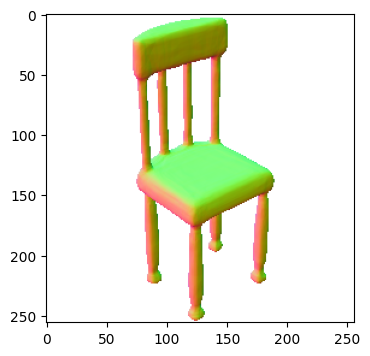

In [2]:
from lib.data.metainfo import MetaInfo
import hydra
from lib.utils.config import load_config
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import cv2 as cv
from torchvision.transforms import v2
from dataclasses import dataclass
import numpy as np
from lib.data.transforms import ToSketch, DilateSketch, ToSilhouette, ToGrayScale
import torch
import matplotlib.pyplot as plt
import time
from torchvision.transforms import Compose, ToTensor
from torchvision.io import read_image, ImageReadMode


def transform(normal):
    _transform = BaseTransform()
    return _transform(normal).to("cuda")


def plot_images(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image)
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images)
        plt.show()


obj_id = 0
metainfo = MetaInfo(data_dir="/home/borth/sketch2shape/data/shapenet_chair_4096")
cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)
cfg.model.prior_obj_id = metainfo.obj_ids[obj_id]
model = hydra.utils.instantiate(cfg.model).to("cuda")
label = metainfo.obj_id_to_label(metainfo.obj_ids[0])
model.latent = model.deepsdf.lat_vecs.weight[label]
normal = model.capture_camera_frame().detach().cpu().numpy()
plot_images(normal)

In [ ]:
transform = BaseTransform(normalize=False)
to_sketch = ToSketch()
fid = FrechetInceptionDistance(feature=2048, normalize=True)

for obj_id in metainfo.obj_ids[:10]:
    img = transform(metainfo.load_sketch(obj_id, "00011"))
    fid.update(img[None, ...], real=True)

for obj_id in metainfo.obj_ids[:10]:
    label = metainfo.obj_id_to_label(metainfo.obj_ids[0])
    model.latent = model.deepsdf.lat_vecs.weight[label]
    img = model.capture_camera_frame().permute(2, 0, 1).detach().cpu()
    img = to_sketch(img)
    fid.update(img[None, ...], real=False)

fid.compute()

# Benchmark Augmentation

In [ ]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        ToSketch(),
        v2.RandomRotation(5),
        DilateSketch(kernel_size=1),
    ]
)
t = 0
n = 256 
for i in range(n):
    s = time.time()
    normal = metainfo.load_normal(metainfo.obj_ids[i], "00011")
    sketch = transforms(normal).permute(1, 2, 0)
    t += time.time() - s
1 / (t / 7)
plot_images(sketch.detach().cpu().numpy())

# Normal To Sketch

In [ ]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        ToSketch(),
        v2.RandomRotation(5, fill=1.0),
        DilateSketch(kernel_size=2),
    ]
)
normal = metainfo.load_normal(metainfo.obj_ids[0], "00011")
sketch = transforms(normal).permute(1, 2, 0)
plot_images(sketch.detach().cpu().numpy())

In [1]:
from lib.eval.clip_score import CLIPScore
from lib.data.metainfo import MetaInfo
import hydra
from lib.utils.config import load_config
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import cv2 as cv
from torchvision.transforms import v2
from dataclasses import dataclass
import numpy as np
from lib.data.transforms import ToSketch, DilateSketch, ToSilhouette, ToGrayScale
import torch
import matplotlib.pyplot as plt

metainfo = MetaInfo(data_dir="/home/borth/sketch2shape/data/shapenet_chair_4096")
cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)
cfg.model.prior_obj_id = metainfo.obj_ids[0]
model = hydra.utils.instantiate(cfg.model).to("cuda")

obj_id = metainfo.obj_ids[0]
transform = BaseTransform(normalize=False)
to_sketch = ToSketch()
# gt sketch
gt_sketch = metainfo.load_sketch(obj_id, "00011")
gt_sketch = transform(gt_sketch)[None, ...]
# rendered sketch
model.latent = model.deepsdf.lat_vecs.weight[0]
rendered_normal = model.capture_camera_frame().permute(2, 0, 1)
rendered_sketch = to_sketch(rendered_normal.detach().cpu())[None, ...]
clip = CLIPScore()
clip.update(gt_sketch, rendered_sketch)
clip.update(gt_sketch, rendered_sketch)
clip.compute()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


98.84614562988281